In [1]:
## load packages
suppressPackageStartupMessages({
  library(emmeans)
  library(ggh4x)
  library(ggpattern)
  library(ggsignif)
  library(Hmisc)
  library(janitor)
  library(patchwork)
  library(phyloseq)
  library(scales)
  library(tidyverse)
})

In [2]:
## paths to directories
repo <- file.path("/Users/abandla/Desktop/2_research/1_manuscripts/2_2020_brunei_peat_fire")
data <- file.path(repo, "1_data")
figures <- file.path(repo, "3_figures")

In [3]:
## set global theme options for plots
btp_theme <- theme(
  axis.text = element_text(size = 16, color = "black"),
  axis.text.y = element_text(margin = margin(0, 10, 0, 10)),
  axis.text.x = element_text(margin = margin(10, 0, 10, 0)),
  axis.title = element_text(size = 18),
  axis.ticks.length = unit(.25, "cm"),
  panel.border = element_rect(linewidth = 0.5, fill = NA),
  panel.background = element_rect(fill = NA),
  panel.grid = element_blank(),
  legend.text = element_text(size = 16),
  legend.title = element_text(size = 18),
  legend.key = element_rect(fill = NA),
  legend.background = element_rect(fill = NA)
)

In [4]:
## import correlograms
correlog_bacteria <- readRDS(file.path(data, "6_icamp", "3_correlograms", "230714_mantel_correlog_bacteria.rds"))
correlog_archaea <- readRDS(file.path(data, "6_icamp", "3_correlograms", "230715_mantel_correlog_archaea.rds"))

In [5]:
## import phyloseq object
btp_fire_ps <- readRDS(file.path(data, "3_phyloseq", "2020_btp_fire_ps.rds"))
btp_fire_ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3928 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 3928 taxa by 7 taxonomic ranks ]

In [6]:
## unnest for plotting
correlog_bacteria_df <- do.call(rbind, lapply(names(correlog_bacteria), function(var_name) {
  correlog_bacteria[[var_name]]$mantel.res %>%
    data.frame() %>%
    mutate(variable = var_name)
}))

In [7]:
## unnest for plotting
correlog_archaea_df <- do.call(rbind, lapply(names(correlog_archaea), function(var_name) {
  correlog_archaea[[var_name]]$mantel.res %>%
    data.frame() %>%
    mutate(variable = var_name)
}))

In [8]:
## plot correlograms
correlog_bacteria_figure <- correlog_bacteria_df %>%
  filter(variable %in% c("pH", "water_temperature", "EC", "DO")) %>%
  filter(!is.na(Pr.corrected.)) %>%
  mutate(
    sig = case_when(
      Pr.corrected. <= 0.05 ~ "0.05",
      Pr.corrected. > 0.05 & Pr.corrected. <= 0.1 ~ "0.1",
      TRUE ~ "ns"
    )
  ) %>%
  ggplot(., aes(x = class.index, y = Mantel.cor)) +
  geom_point(aes(fill = sig), shape = 21, size = 3) +
  geom_line() +
  facet_wrap(~variable,
    nrow = 1,
    labeller = as_labeller(c(
      "DO" = "DO",
      "EC" = "EC",
      "pH" = "pH",
      "water_temperature" = "Temperature"
    ))
  ) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    legend.position = "none",
    aspect.ratio = 1,
    strip.text = element_text(size = 16),
    strip.background = element_blank(),
    panel.spacing.x = unit(2, "lines")
  ) +
  xlab("PD class index") +
  ylab("Mantel R") +
  scale_fill_manual(
    values = c("0.05" = "#000000", "ns" = "#ffffff", "0.1" = "#d3d3d3")
  ) +
  geom_hline(yintercept = 0, color = "red")

In [9]:
## plot correlograms
correlog_archaea_figure <- correlog_archaea_df %>%
  filter(variable %in% c("pH", "water_temperature", "EC", "DO")) %>%
  filter(!is.na(Pr.corrected.)) %>%
  mutate(
    sig = case_when(
      Pr.corrected. <= 0.05 ~ "0.05",
      Pr.corrected. > 0.05 & Pr.corrected. <= 0.1 ~ "0.1",
      TRUE ~ "ns"
    )
  ) %>%
  ggplot(., aes(x = class.index, y = Mantel.cor)) +
  geom_point(aes(fill = sig), shape = 21, size = 3) +
  geom_line() +
  facet_wrap(~factor(variable),
    nrow = 1,
    labeller = as_labeller(c(
      "DO" = "DO",
      "EC" = "EC",
      "pH" = "pH",
      "water_temperature" = "Temperature"
    ))
  ) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    legend.position = "none",
    aspect.ratio = 1,
    strip.text = element_text(size = 16),
    strip.background = element_blank(),
    panel.spacing.x = unit(2, "lines")
  ) +
  xlab("PD class index") +
  ylab("Mantel R") +
  scale_fill_manual(
    values = c("0.05" = "#000000", "ns" = "#ffffff", "0.1" = "#d3d3d3")
  ) +
  geom_hline(yintercept = 0, color = "red")

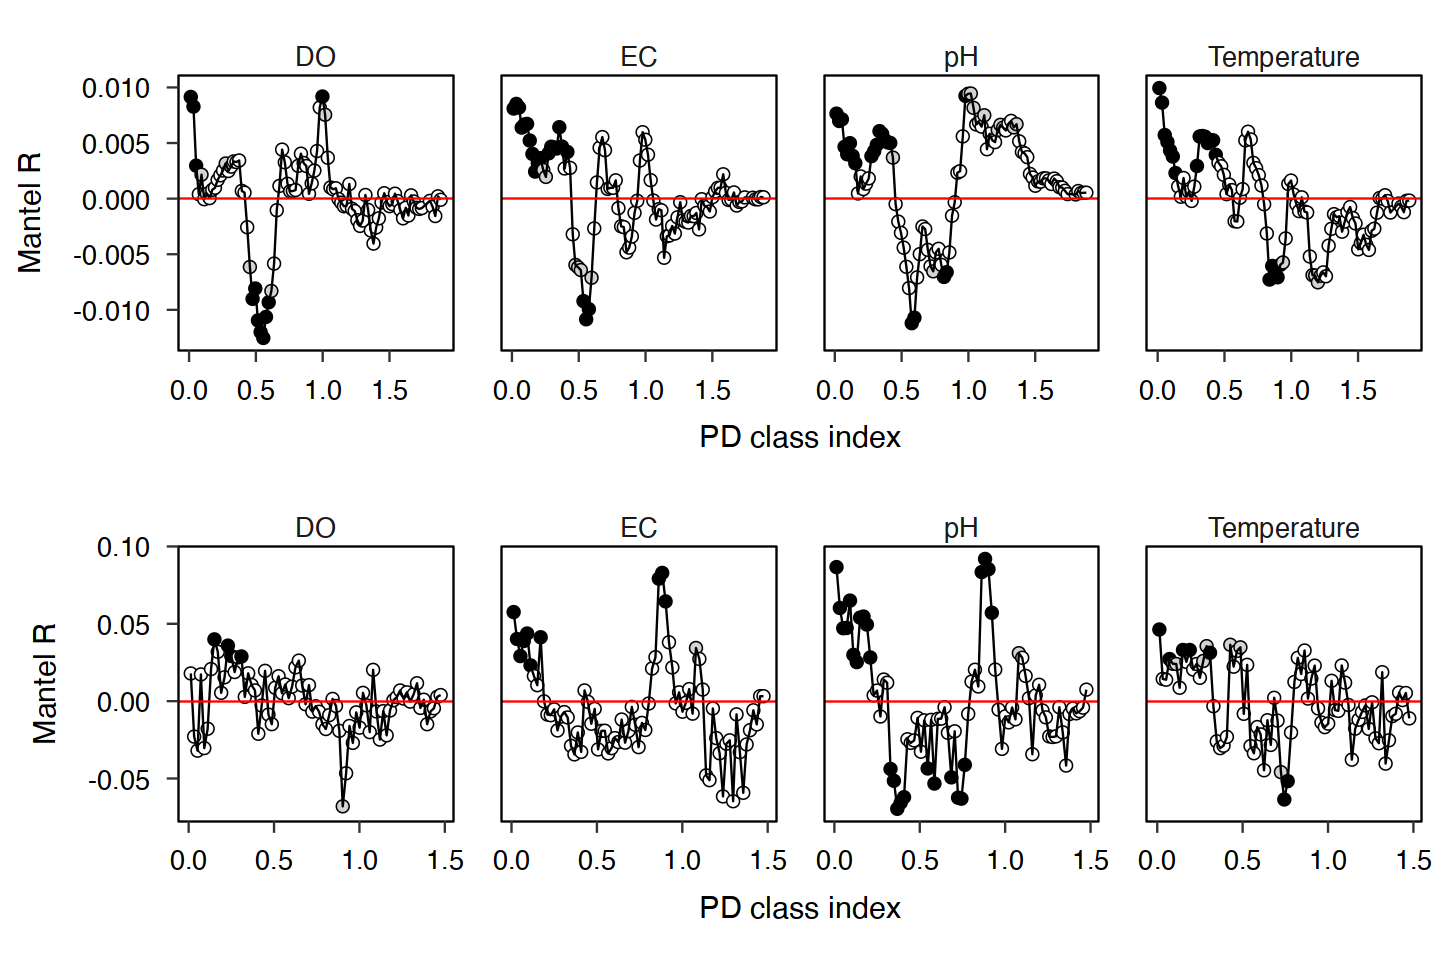

In [10]:
## view plot
options(repr.plot.width = 12, repr.plot.height = 8)
correlog_bacteria_figure / correlog_archaea_figure

In [11]:
## import process bootstrap results
boot_bacteria <- readRDS(file.path(data, "6_icamp", "5_null_model", "1_bacteria", "230720_icboot_results_bacteria.rds"))
boot_archaea <- readRDS(file.path(data, "6_icamp", "5_null_model", "2_archaea", "230720_icboot_results_archaea.rds"))

In [12]:
## unnest
boot_bacteria_df <- do.call(rbind, lapply(names(boot_bacteria), function(var_name) {
  boot_bacteria[[var_name]]$summary %>%
    select(Group, Process, Observed, Mean, Stdev) %>%
    mutate(Mean = as.numeric(Mean), Stdev = as.numeric(Stdev)) %>%
    mutate(depth = var_name)
})) %>%
  mutate(domain = "Bacteria")

In [13]:
## unnest
boot_archaea_df <- do.call(rbind, lapply(names(boot_archaea), function(var_name) {
  boot_archaea[[var_name]]$summary %>%
    select(Group, Process, Observed, Mean, Stdev) %>%
    mutate(Mean = as.numeric(Mean), Stdev = as.numeric(Stdev)) %>%
    mutate(depth = var_name)
})) %>%
  mutate(domain = "Archaea")

In [14]:
## unnest
boot_bacteria_compare_df <- do.call(rbind, lapply(names(boot_bacteria), function(var_name) {
  boot_bacteria[[var_name]]$compare %>%
    mutate(depth = var_name)
})) %>%
  mutate(domain = "Bacteria")

In [15]:
## unnest
boot_archaea_compare_df <- do.call(rbind, lapply(names(boot_archaea), function(var_name) {
  boot_archaea[[var_name]]$compare %>%
    mutate(depth = var_name)
})) %>%
  mutate(domain = "Archaea")

In [16]:
## import bin contributions to processes
bin_process_bacteria <- read.csv(
  file.path(data, "6_icamp", "5_null_model", "1_bacteria", "2020_btp_bacteria_bin_contribute_to_process_each_group.csv")
)

In [17]:
## import bin contributions to processes
bin_process_archaea <- read.csv(
  file.path(data, "6_icamp", "5_null_model", "2_archaea", "2020_btp_archaea_bin_contribute_to_process_each_group.csv")
)

In [18]:
## combine and plot
processes_combined_figure <- bind_rows(boot_bacteria_df, boot_archaea_df) %>%
  filter(Process %nin% c("Heterogeneous.Selection", "Homogenizing.Dispersal")) %>%
  ggplot(., aes(x = depth, y = Mean, color = Group)) +
  geom_point(position = position_dodge(width = 0.8), size = 4, shape = 1, stroke = 1.1) +
  geom_errorbar(aes(ymin = Mean - Stdev, ymax = Mean + Stdev),
    width = 0.4,
    position = position_dodge(width = 0.8),
    linewidth = 0.8
  ) +
  geom_line(aes(group = Group), position = position_dodge(width = 0.8), linewidth = 0.8) +
  facet_grid2(
    domain ~ Process,
    scales = "free_y",
    independent = "y",
    labeller = as_labeller(
      default = label_wrap_gen(10), c(
        "Dispersal.Limitation" = "Dispersal Limitation",
        "Drift.and.Others" = "Drift",
        "Homogeneous.Selection" = "Homogeneous Selection",
        "Stochasticity" = "Stochasticity",
        "Bacteria" = "Bacteria",
        "Archaea" = "Archaea"
      )
    )
  ) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    legend.position = "none",
    aspect.ratio = 1,
    strip.text = element_text(size = 18),
    strip.background = element_rect(fill = "#f0f0f0"),
    panel.spacing = unit(1, "lines"),
    panel.grid.major = element_line(color = "#d3d3d3"),
    panel.grid.minor = element_line(color = "#d3d3d3"),
    strip.placement = "outside",
    axis.text.x = element_text(size = 15)
  ) +
  scale_x_discrete(labels = c("Surface", "Mid", "Deep")) +
  scale_color_manual(
    "PSF",
    values = c("#e66101", "#1a9641"),
    labels = c("Burnt", "Intact")
  ) +
  facetted_pos_scales(y = list(
    Process == "Dispersal.Limitation" ~ scale_y_continuous(limits = c(0, 0.8), n.breaks = 3),
    Process == "Drift.and.Others" ~ scale_y_continuous(limits = c(0, 0.8), n.breaks = 3),
    Process == "Heterogeneous.Selection" ~ scale_y_continuous(limits = c(0, 0.1), n.breaks = 3),
    Process == "Homogeneous.Selection" ~ scale_y_continuous(limits = c(0, 1.2), n.breaks = 3, breaks = c(0, 0.5, 1)),
    Process == "Homogenizing.Dispersal" ~ scale_y_continuous(limits = c(-0.005, 0.2), n.breaks = 3),
    Process == "Stochasticity" ~ scale_y_continuous(limits = c(0, 1), n.breaks = 3)
  )) +
  xlab("") +
  ylab("% Turnovers") +
  geom_signif(
    data = data.frame(
      Process = c("Dispersal.Limitation", "Homogeneous.Selection", "Stochasticity"),
      domain = c("Bacteria")
    ),
    aes(
      y_position = c(0.7, 0.85, 0.85),
      xmin = c(2.8, 2.8, 2.8),
      xmax = c(3.2, 3.2, 3.2),
      annotations = c("**", "*", "*")
    ),
    tip_length = 0.05,
    manual = T,
    textsize = 8,
    family = "Helvetica",
    inherit.aes = FALSE
  ) +
  geom_signif(
    data = data.frame(
      Process = c("Drift.and.Others", "Drift.and.Others", "Stochasticity", "Homogeneous.Selection"),
      domain = c("Archaea")
    ),
    aes(
      y_position = c(0.7, 0.7, 0.85, 1.05),
      xmin = c(0.8, 2.8, 2.8, 2.8),
      xmax = c(1.2, 3.2, 3.2, 3.2),
      annotations = c("*", "**", "*", "*")
    ),
    tip_length = 0.05,
    manual = T,
    textsize = 8,
    family = "Helvetica",
    inherit.aes = FALSE
  )

Warning message in geom_signif(data = data.frame(Process = c("Dispersal.Limitation", :
“Ignoring unknown aesthetics: y_position, xmin, xmax, and annotations”
Warning message in geom_signif(data = data.frame(Process = c("Drift.and.Others", :
“Ignoring unknown aesthetics: y_position, xmin, xmax, and annotations”


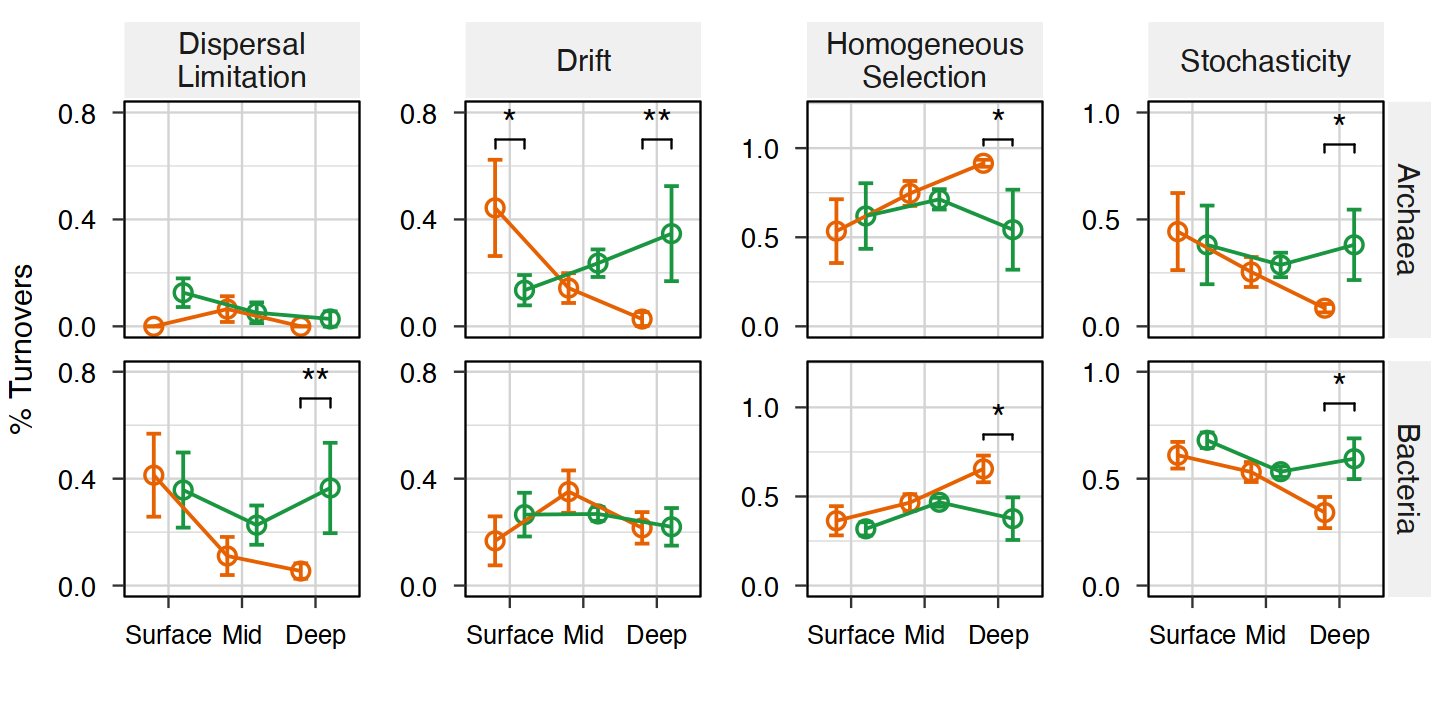

In [19]:
## view plot
options(repr.plot.width = 12, repr.plot.height = 6)
processes_combined_figure

In [20]:
## community-level processes 
## relative importance for archaea
community_process_importance <- read.csv(
  file.path(
    data,
    "6_icamp",
    "5_null_model",
    "2_archaea",
    "2020_btp_archaea_process_importance_each_group.csv"
  ),
  header = TRUE
) %>%
  select(-one_of("Method", "GroupBasedOn")) %>%
  pivot_longer(-Group, names_to = "Index", values_to = "process_per") %>%
  mutate(process_per = as.numeric(process_per) * 100) %>%
  mutate(bin = "Community") %>%
  select(Group, Index, bin, process_per)

In [21]:
## process importance figure
process_importance_figure <- read.csv(
  file.path(
    data,
    "6_icamp",
    "5_null_model",
    "2_archaea",
    "2020_btp_archaea_process_importance_each_bin_each_group.csv"
  )
) %>%
  filter(!str_detect(Index, "Dominant")) %>%
  select(-one_of("Method", "GroupBasedOn")) %>%
  pivot_longer(-c("Group", "Index"), names_to = "bin", values_to = "process_per") %>%
  mutate(process_per = as.numeric(process_per) * 100) %>%
  bind_rows(community_process_importance) %>%
  filter(str_detect(Group, "_95-100")) %>%
  separate(Group, c("Group", "Depth"), "_") %>%
  mutate(dominant_process = case_when(
    Group == "Burnt" & bin == "Community" & Index == "HoS" ~ "Dominant",
    Group == "Burnt" & bin == "bin1" & Index == "HoS" ~ "Dominant",
    Group == "Burnt" & bin == "bin5" & Index == "HoS" ~ "Dominant",
    Group == "Intact" & bin == "bin4" & Index == "DR" ~ "Dominant",
    Group == "Intact" & bin == "bin5" & Index == "HoS" ~ "Dominant",
    TRUE ~ "NA"
  )) %>%
  ggplot(., aes(x = fct_rev(Group), y = process_per, fill = Index, pattern = dominant_process)) +
  geom_bar(stat = "identity", width = 1) +
  geom_bar_pattern(
    color = "black",
    width = 1,
    stat = "identity",
    pattern_color = "black",
    pattern_alpha = 0.2,
    pattern_spacing = 0.08,
    show.legend = TRUE
  ) +
  scale_pattern_manual(values = c("Dominant" = "stripe", "NA" = "none")) +
  facet_wrap(~bin,
    nrow = 3,
    labeller = as_labeller(c(
      "Community" = "Community",
      "bin1" = "Methanomicrobia",
      "bin2" = "Nitrososphaeria-1",
      "bin3" = "Nitrososphaeria-2",
      "bin4" = "Nitrososphaeria-3",
      "bin5" = "Bathyarchaeia",
      "bin6" = "Thermoplasmata"
    ))
  ) +
  coord_flip(clip = "off") +
  theme(legend.position = "none") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = c(0, 0)) +
  btp_theme +
  theme(
    legend.position = "none",
    legend.key.size = unit(0.7, "cm"),
    legend.margin = margin(0, 0, -27, 0),
    strip.background = element_rect(fill = NA),
    strip.text.x = element_text(size = 16),
    panel.spacing.x = unit(2, "lines")
  ) +
  scale_fill_manual(
    "Process",
    values = c("#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3"),
    labels = c("DL", "DR", "HD", "VS", "HS")
  ) +
  guides(
    fill = guide_legend(
      nrow = 2,
      byrow = TRUE,
      override.aes = list(color = "black", size = 1.5)
    ),
    pattern = guide_legend("",
      nrow = 1, byrow = TRUE,
      override.aes = list(
        fill = NA,
        pattern = "stripe",
        color = "black",
        pattern_alpha = 0.4,
        pattern_spacing = 0.01,
        size = 1.5
      )
    )
  ) +
  xlab("") +
  ylab("% Turnovers")

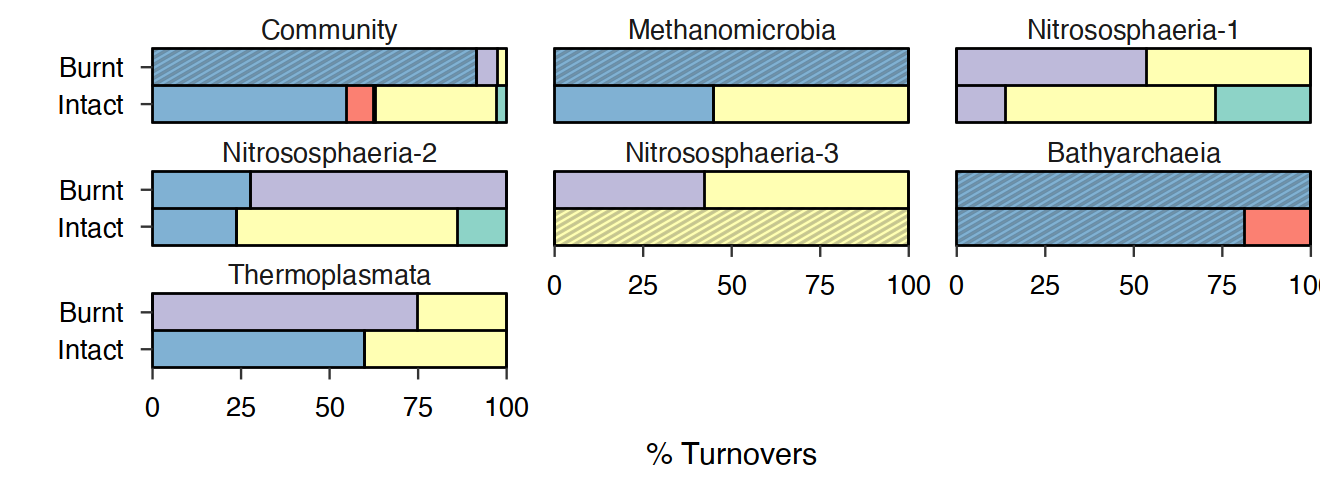

In [22]:
## view plot
options(repr.plot.width = 11, repr.plot.height = 4)
process_importance_figure